# Module 4

### Part 1

Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2024 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land.

In [1]:
# Importing packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from eofs.xarray import Eof
import pandas as pd

In [37]:
import cdsapi

# Downloading the monthly averaged SST and total column water vapor
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "sea_surface_temperature",
        "total_column_water_vapour"
    ],
    "year": [
        "1979", "1980", "1981",
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021", "2022", "2023",
        "2024"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [65, 120, -65, 300]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download("era5_pacific_sst_tcwv_1979_2024.nc")

2025-10-24 12:19:19,916 INFO Request ID is be4e3fc0-c71d-4f5f-9caa-70aa65d5e861
2025-10-24 12:19:20,130 INFO status has been updated to accepted
2025-10-24 12:19:29,128 INFO status has been updated to successful


85ea0db3fca4ccec57d2f30e78fee0c7.nc:   0%|          | 0.00/537M [00:00<?, ?B/s]

'era5_pacific_sst_tcwv_1979_2024.nc'

In [4]:
# Downloading the land sea mask
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": ["land_sea_mask"],
    "year": [
        "1979", "1980", "1981",
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021", "2022", "2023",
        "2024"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [65, 120, -65, 300]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download("era5_pacific_ls_mask.nc")

2025-10-24 12:30:29,698 INFO Request ID is af51c78f-2e0e-4601-a194-77b217b506e8
2025-10-24 12:30:29,989 INFO status has been updated to accepted
2025-10-24 12:30:35,371 INFO status has been updated to running
2025-10-24 12:30:38,959 INFO status has been updated to successful


cd095c22bb7309517a8844d25783a680.nc:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

'era5_pacific_ls_mask.nc'

Dataset variables: ['lsm']
Dataset dimensions: FrozenMappingWarningOnValuesAccess({'valid_time': 552, 'latitude': 521, 'longitude': 721})
Time range: 1979-01-01T00:00:00.000000000 to 2024-12-01T00:00:00.000000000


In [5]:
# Loading the data
ds = xr.open_dataset('era5_pacific_sst_tcwv_1979_2024.nc')
mask = xr.open_dataset('era5_pacific_ls_mask.nc')

In [6]:
# Quick checks of the downloaded dataset
print(list(mask.data_vars))
print(ds.dims)
print(ds.valid_time.min().values, "to", ds.valid_time.max().values)

['lsm']
FrozenMappingWarningOnValuesAccess({'valid_time': 552, 'latitude': 521, 'longitude': 721})
1979-01-01T00:00:00.000000000 to 2024-12-01T00:00:00.000000000


In [7]:
# Making mask of oceans
ocean_mask = mask.lsm == 0
ds = ds.where(ocean_mask)
# Saving the data to a new 
ds.to_netcdf('era_pacific_sst_tcwv_1979_2024_masked.nc')

### Part 2

In [8]:
# Adding helper functions

def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z

In [9]:
# Opening the masked data set
ds2 = xr.open_dataset('era_pacific_sst_tcwv_1979_2024_masked.nc')

# Detrending the data using the helper in the hw file
detrended = linear_detrend(ds2[["sst", "tcwv"]], time_dim="valid_time")

# Removing seasonal cycles and standardizing 
anom, z = monthly_anom_and_z(detrended, time_dim="valid_time", base_period=("1981-01-01", "2010-12-31"))

c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\numpy\

### Part 3

In [10]:
sst_anom = z.sst
# Renaming valid_time to time so eofs works
sst_anom = sst_anom.rename({'valid_time': 'time'})

# Apply latitude weighting by squre root of cosine of lat like in M04N05
coslat = np.cos(np.deg2rad(sst_anom.latitude.values))
wgts = np.sqrt(coslat)[..., np.newaxis]

# Making the EOF solver
solver = Eof(sst_anom, weights=wgts)

# Get the first 5 EOFs as correlations
eofs = solver.eofsAsCorrelation(neofs=5)
pcs = solver.pcs(npcs=5, pcscaling=1)

c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effe

Text(0.5, 0.98, 'First 5 EOFs of Pacific SST')

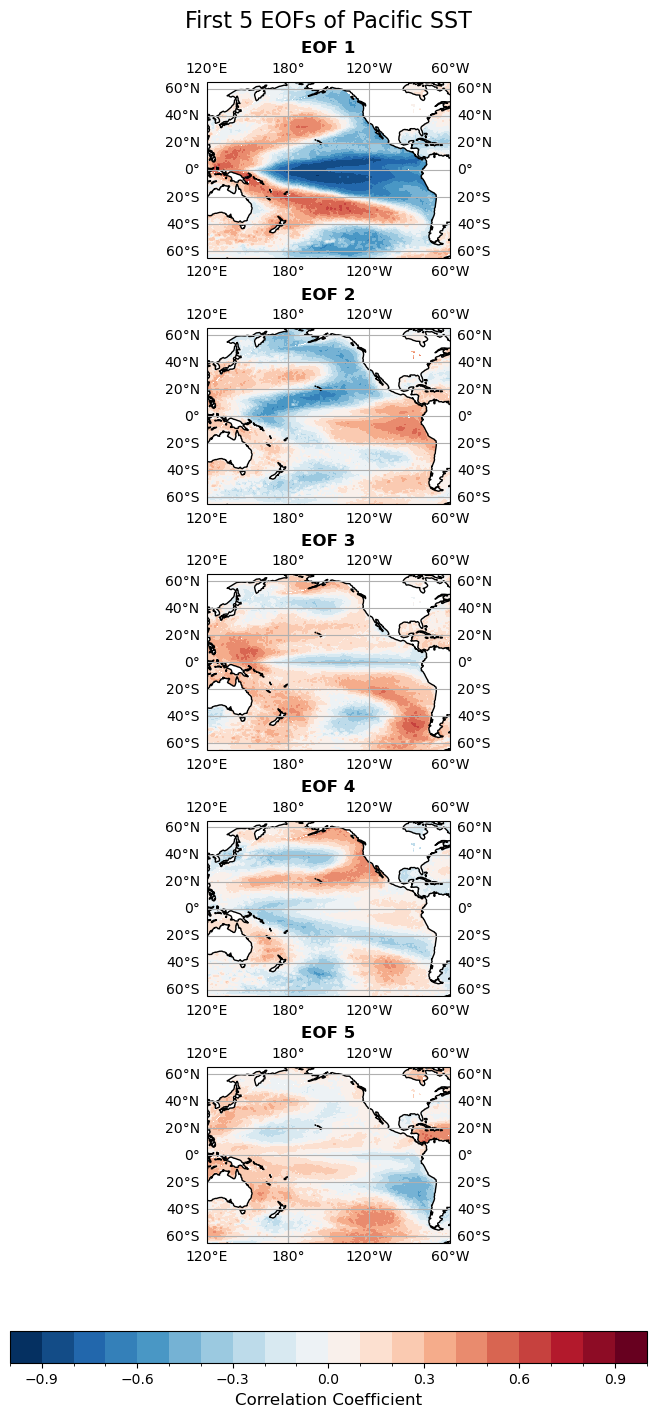

In [11]:
# Making maps of the first 5 EOFs

# Create figure with 5 subplots
fig, axes = plt.subplots(5, 1, figsize=(16, 14),
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                         constrained_layout=True)
axes = axes.flatten()

clevs = np.linspace(-1, 1, 21)

for i in range(5):
    ax = axes[i]
    
    # Plot EOF i
    im = eofs[i].plot.contourf(
        ax=ax,
        levels=clevs,
        cmap='RdBu_r',
        add_colorbar=False,
        transform=ccrs.PlateCarree(),
    )
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    ax.gridlines(draw_labels=True)
    ax.set_title(f'EOF {i+1}', fontsize=12, fontweight='bold')
    

# Add shared colorbar
cbar = fig.colorbar(im, ax=axes[:5], orientation='horizontal', shrink=0.4)
cbar.set_label('Correlation Coefficient', fontsize=12)

plt.suptitle('First 5 EOFs of Pacific SST', fontsize=16)

### Part 4

In [12]:
# Calculating the variance fractions for the EOFs
varfrac = solver.varianceFraction()

(8.450422610095751e-16, 0.18828679621219635)

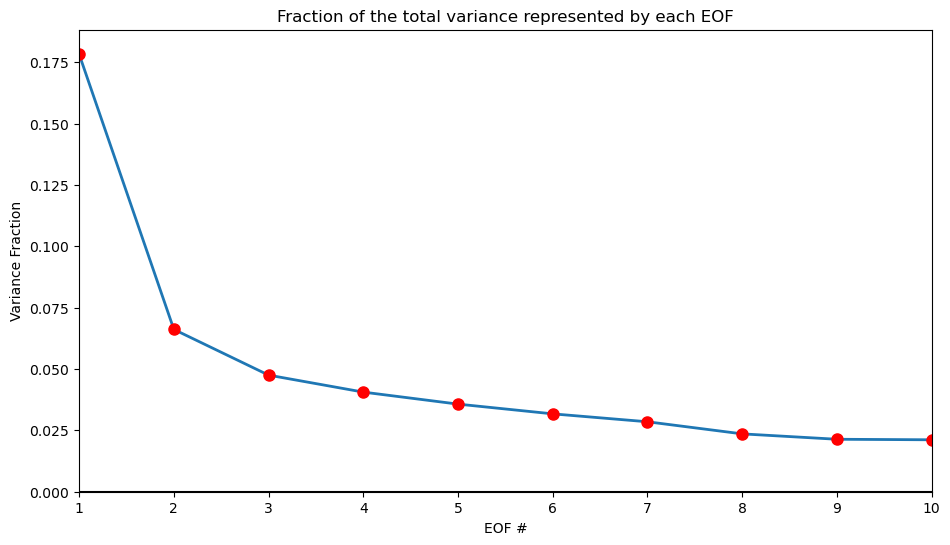

In [13]:
# Plot the fraction of variance explained by each EOF - code from M04N05
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10], linewidth=2)
plt.plot(eof_num, varfrac[0:10], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

### Part 5

In [14]:
# Reconstructing the SST field using the first 5 EOFs

reconstruction = solver.reconstructedField(5)
reconstruction

# Calculate the correlatrion 
correlation = xr.corr(reconstruction, sst_anom, dim='time')

c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


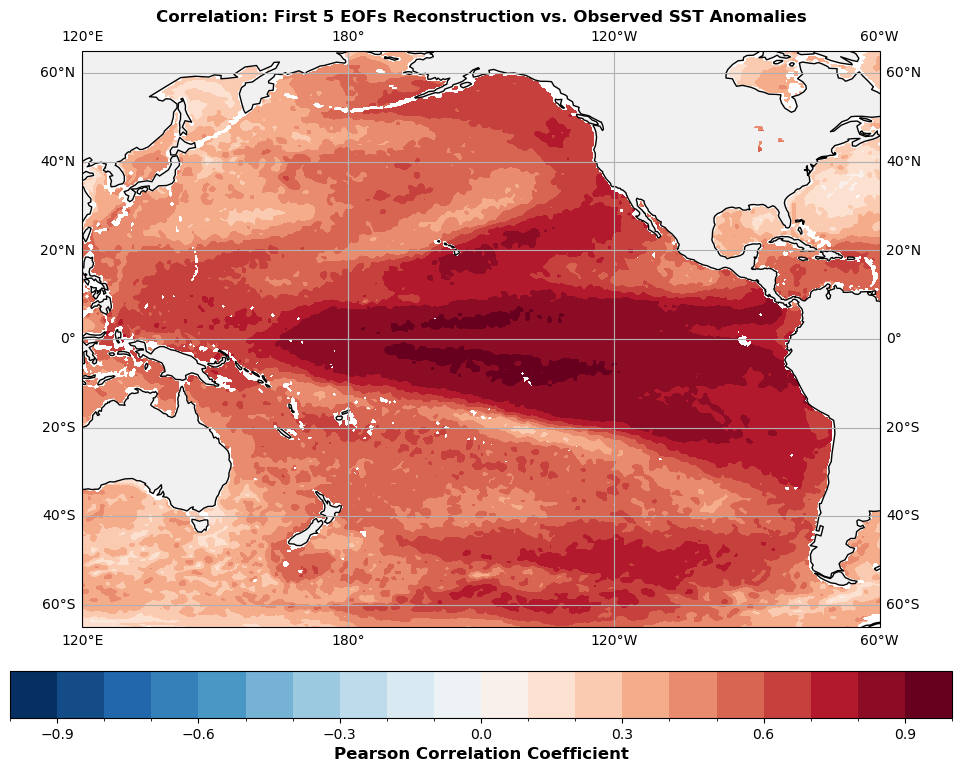

In [23]:
# Plot correlation map
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

clevs = np.linspace(-1, 1, 21)

im = correlation.plot.contourf(
    ax=ax,
    levels=clevs,
    cmap='RdBu_r',
    add_colorbar=False,
    transform=ccrs.PlateCarree()
)

# Constrain to Pacific Basin
ax.set_extent([120, 300, -65, 65], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.gridlines(draw_labels=True)

# Colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.06, shrink=0.6)
cbar.set_label('Pearson Correlation Coefficient', fontsize=12, fontweight='bold')

ax.set_title('Correlation: First 5 EOFs Reconstruction vs. Observed SST Anomalies', 
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### Part 6

In [21]:
# Pulling out just the first EOF
pc1 = pcs[:, 0]

# Making an unmasked ds - same steps as above
ds_unmasked = xr.open_dataset('era5_pacific_sst_tcwv_1979_2024.nc')

detrended_unmasked = linear_detrend(ds_unmasked[["sst", "tcwv"]], time_dim="valid_time")
anom_unmasked, z_unmasked = monthly_anom_and_z(detrended_unmasked, time_dim="valid_time", base_period=("1981-01-01", "2010-12-31"))

tcwv_anom = z_unmasked.tcwv
# Renaming valid_time to time so eofs works
tcwv_anom = tcwv_anom.rename({'valid_time': 'time'})

correl_tcwv = xr.corr(pc1, tcwv_anom, dim='time')

c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\numpy\

c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


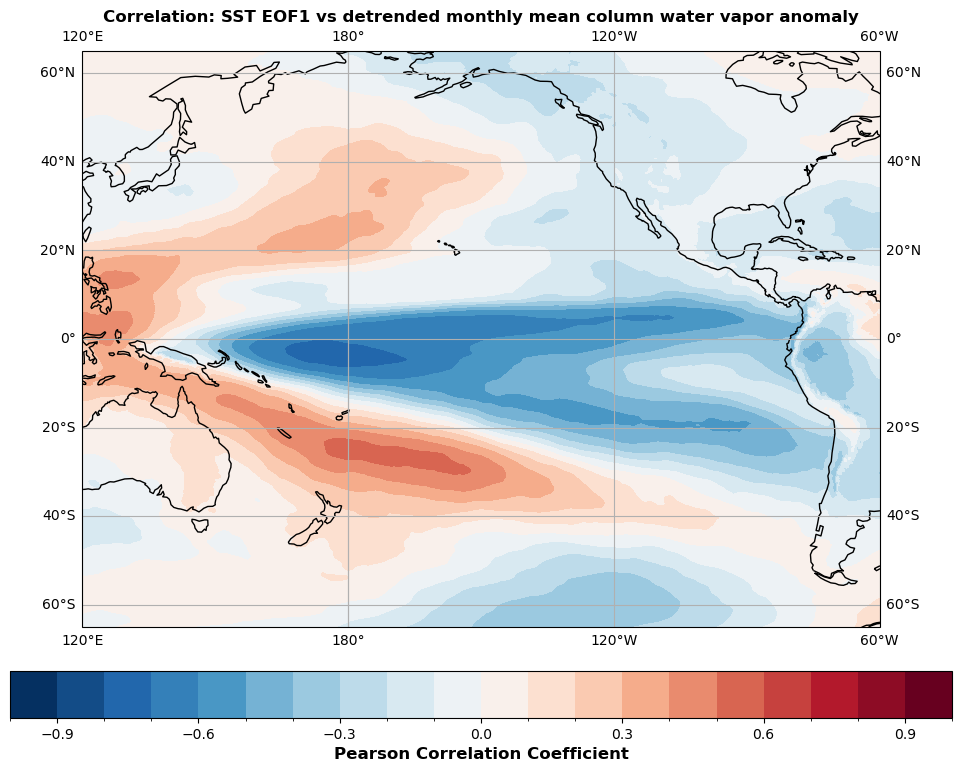

In [24]:
# Plot correlation map
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

clevs = np.linspace(-1, 1, 21)

im = correl_tcwv.plot.contourf(
    ax=ax,
    levels=clevs,
    cmap='RdBu_r',
    add_colorbar=False,
    transform=ccrs.PlateCarree()
)

# Constrain to Pacific Basin
ax.set_extent([120, 300, -65, 65], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.gridlines(draw_labels=True)

# Colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.06, shrink=0.6)
cbar.set_label('Pearson Correlation Coefficient', fontsize=12, fontweight='bold')

ax.set_title('Correlation: SST EOF1 vs detrended monthly mean column water vapor anomaly', 
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# My takeaways from Q6
When looking at EOF1, it appears that there's a strong negative correlation between SST and water vapor in the central pacific. Because the sign is arbitrary, positive values could be either La Nina or El Nino. Because the map is showing negative correlation when EOF1 increases, it likely means that positive values show La Nina conditions.